# INTERNET Notebook

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score, f1_score

import optuna
import catboost as cb
import xgboost as xgb
import lightgbm as lgb


In [176]:
df = pd.read_csv('df_train_internet.csv')

In [177]:
num_col = ['tenure', 'totalcharges', 'monthlycharges']
target = 'churn'
X_col = [c for c in df.columns if c != target]
cat_col = [c for c in X_col if c not in num_col]


<Axes: xlabel='churn', ylabel='Count'>

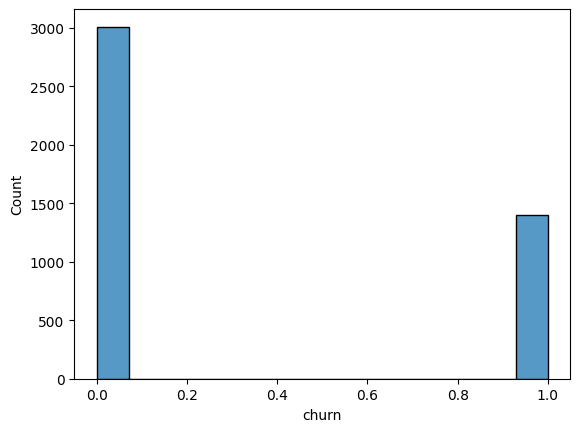

In [178]:
sns.histplot(data=df, x='churn')

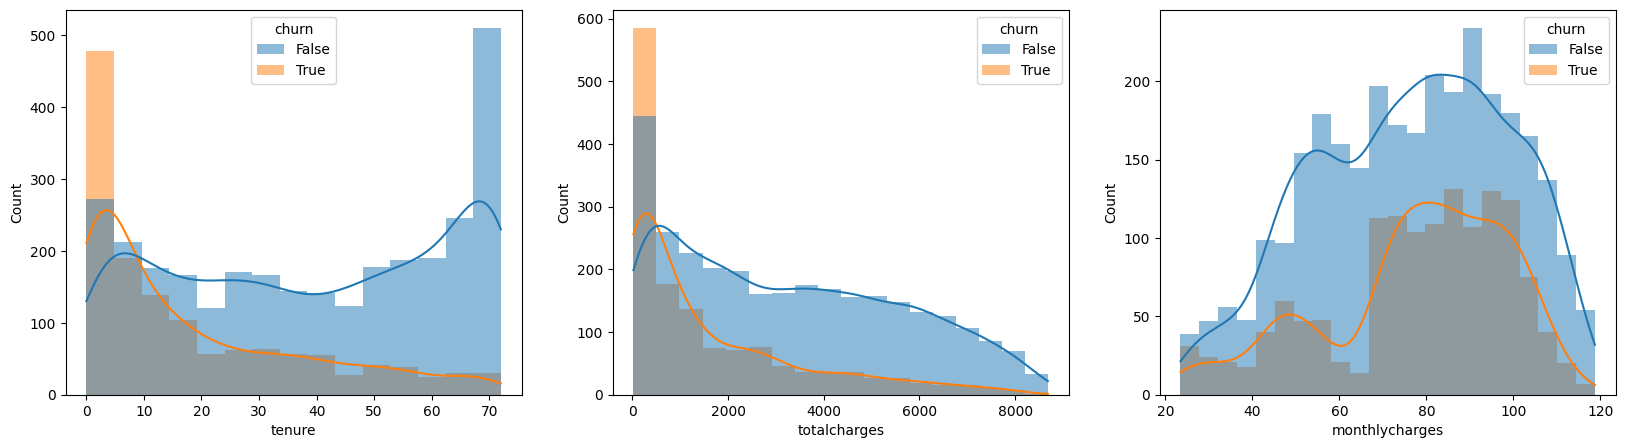

In [179]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for col, ax in zip(num_col, axes):
    sns.histplot(
        data=df, x=col, kde=True, ax=ax, hue=target, binwidth=df[col].std() /5, edgecolor=None
    )

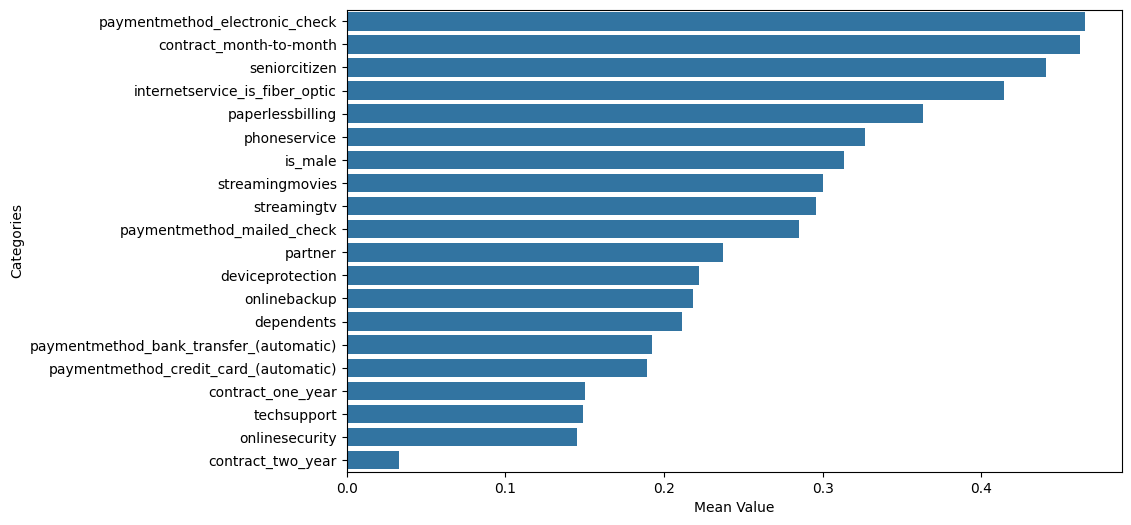

In [180]:
probability_of_churn_given_flag = df[df[target]][cat_col].sum() / df[cat_col].sum()
probability_of_churn_given_flag = probability_of_churn_given_flag.sort_values(ascending = False)

plt.figure(figsize=(10, 6))
sns.barplot(data=probability_of_churn_given_flag, orient= 'h')
plt.xlabel('Mean Value')
plt.ylabel('Categories')
plt.show()

In [181]:
scaler = RobustScaler()
df_scaled = df.copy()
df_scaled.loc[:, num_col] = scaler.fit_transform(df_scaled[num_col])

In [182]:
pca = PCA()
X_pca = pca.fit_transform(df_scaled[X_col])
importances = pca.explained_variance_ratio_ / np.sum(pca.explained_variance_ratio_)
print(pd.Series(importances)[:3])

0    0.266341
1    0.141268
2    0.052790
dtype: float64


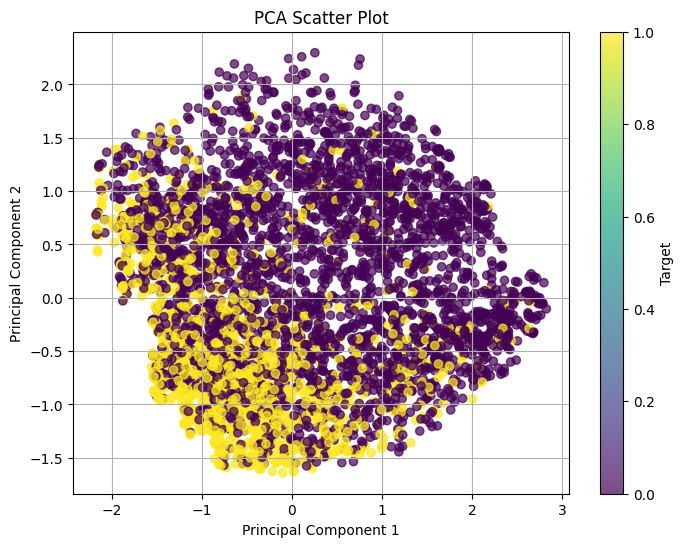

In [183]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()


In [184]:
fig = px.scatter_3d(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    z=X_pca[:, 2],
    color=df[target],
    labels={"x": "Principal Component 1", "y": "Principal Component 2", "z": "Principal Component 3"},
    title="3D PCA Scatter Plot",
)

fig.update_traces(marker={"size": 3})
fig.update_layout(width=1000, height=800)
fig.show()

In [185]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(df_scaled[X_col])

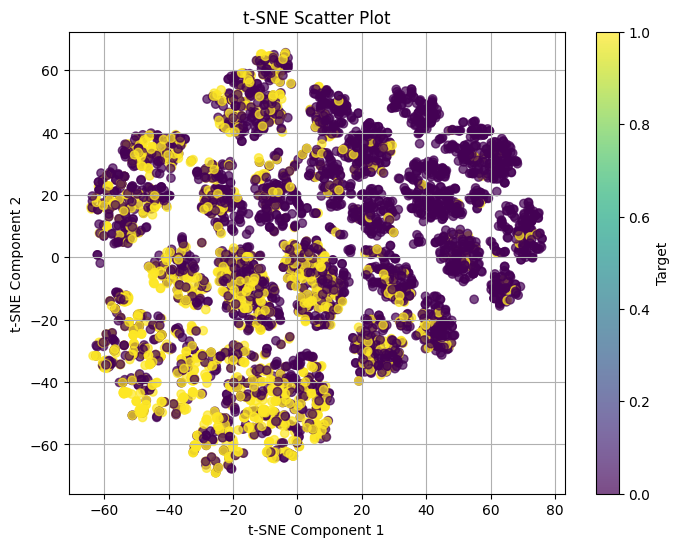

In [186]:

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df[target], cmap="viridis", alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Scatter Plot")
plt.colorbar(label="Target")
plt.grid()
plt.show()

## Modelling

In [154]:
X = df[X_col]
y = df[target]

In [155]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## CatBoost

#### Parameters research

In [156]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 1000),
        'depth': trial.suggest_int('depth', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-2, 0.1),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 16, 20),
        'subsample': trial.suggest_float('subsample', 0.4, 0.7),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 0, 5),
        'random_strength': trial.suggest_float('random_strength', 0.1, 2),
        'loss_function': 'Logloss',
        'eval_metric': 'Accuracy',
        'task_type': 'CPU',
    }

    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
    
        # Create CatBoost Pool
        train_pool = cb.Pool(X_train, y_train)
        valid_pool = cb.Pool(X_valid, y_valid)
        
        # Initialize and train model
        model = cb.CatBoostClassifier(**param, 
                                      verbose=False, 
                                      early_stopping_rounds=15
                                      )
        model.fit(train_pool, 
                  eval_set=valid_pool, 
                  plot=False)
        
        # Predict and calculate accuracy
        preds = model.predict(valid_pool)
        scores.append(roc_auc_score(y_valid, preds))
    
    mean_score = np.mean(scores)
    return mean_score

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42),  pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:49:11,112] A new study created in memory with name: no-name-236bfa47-f301-4209-b29e-5be4f8e8cbd3
[I 2024-12-11 15:49:12,743] Trial 0 finished with value: 0.7303826086060554 and parameters: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}. Best is trial 0 with value: 0.7303826086060554.
[I 2024-12-11 15:49:14,296] Trial 1 finished with value: 0.7150544978826044 and parameters: {'iterations': 933, 'depth': 7, 'learning_rate': 0.0737265320016441, 'l2_leaf_reg': 16.082337977183208, 'subsample': 0.6909729556485982, 'min_data_in_leaf': 4, 'random_strength': 0.5034443102887247}. Best is trial 0 with value: 0.7303826086060554.
[I 2024-12-11 15:49:15,420] Trial 2 finished with value: 0.7039536865217577 and parameters: {'iterations': 591, 'depth': 4, 'learning_rate': 0.0373818018663584, 'l2_leaf_reg': 18.09902572652895, 'subsamp

Best trial: {'iterations': 687, 'depth': 8, 'learning_rate': 0.07587945476302646, 'l2_leaf_reg': 18.394633936788146, 'subsample': 0.44680559213273097, 'min_data_in_leaf': 0, 'random_strength': 0.21035886311957896}


#### Testing

In [173]:
best_params = {'iterations': 862, 'depth': 8, 'learning_rate': 0.09169350952718329, 'l2_leaf_reg': 17.280624018040182, 'subsample': 0.48223683658151323, 'min_data_in_leaf': 5, 'random_strength': 0.4117055183567362}
model = cb.CatBoostClassifier(**best_params, verbose=False)
train_pool = cb.Pool(X, y)
test_pool = cb.Pool(X_test, y_test)
model.fit(train_pool)

In [174]:
print('CatBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

CatBoost scores
Accuracy: 0.7556732223903178
RocAuc: 0.6964282410527624
F1 : 0.5810635538261998


## XGBoost

#### Parameters research

In [159]:
def objective(trial):
    param = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        'n_estimators': trial.suggest_int('n_estimators', 800, 1200), 
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-3, 2),
        "alpha": trial.suggest_float("alpha", 1e-3, 2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "eta": trial.suggest_float("eta", 1e-2, 0.3),
        "gamma": trial.suggest_float("gamma", 1e-3, 3),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "subsample": trial.suggest_float("subsample", 0.6, 0.95),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.95),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["depthwise", "lossguide"]
        ),
        "max_bin": trial.suggest_int("max_bin", 64, 255)
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
    
        model = xgb.XGBClassifier(**param, early_stopping_rounds=15)
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
        preds = model.predict(X_valid)
        scores.append(accuracy_score(y_valid, preds))
    
    mean_score = np.mean(scores)   
    return mean_score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))
study.optimize(objective, n_trials=20)

print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:49:47,592] A new study created in memory with name: no-name-19f6a963-0966-4ce8-a665-a08eee758fb6
[I 2024-12-11 15:49:48,049] Trial 0 finished with value: 0.7205070819148489 and parameters: {'n_estimators': 950, 'booster': 'gbtree', 'lambda': 1.197718309909876, 'alpha': 0.31288126224443064, 'max_depth': 4, 'eta': 0.026844247528777843, 'gamma': 2.5986622611790304, 'min_child_weight': 5, 'subsample': 0.8478254022286159, 'colsample_bytree': 0.6072045730035308, 'grow_policy': 'depthwise', 'max_bin': 104}. Best is trial 0 with value: 0.7205070819148489.
[I 2024-12-11 15:49:50,345] Trial 1 finished with value: 0.7681629050561088 and parameters: {'n_estimators': 872, 'booster': 'dart', 'lambda': 1.0499881068328434, 'alpha': 0.8644580922655895, 'max_depth': 5, 'eta': 0.18743733946949004, 'gamma': 0.41934208809547346, 'min_child_weight': 3, 'subsample': 0.7282266451527921, 'colsample_bytree': 0.7596244944759625, 'grow_policy': 'depthwise', 'max_bin': 162}. Best is trial 1 with v

Best trial: {'n_estimators': 990, 'booster': 'gbtree', 'lambda': 0.6465611069976087, 'alpha': 1.1963315346529115, 'max_depth': 3, 'eta': 0.11623676467831479, 'gamma': 1.6510175761428012, 'min_child_weight': 1, 'subsample': 0.6628472786517728, 'colsample_bytree': 0.874236658152416, 'grow_policy': 'depthwise', 'max_bin': 109}


#### Testing

In [169]:
best_params = {'n_estimators': 990, 'booster': 'gbtree', 'lambda': 0.6465611069976087, 'alpha': 1.1963315346529115, 'max_depth': 3, 'eta': 0.11623676467831479, 'gamma': 1.6510175761428012, 'min_child_weight': 1, 'subsample': 0.6628472786517728, 'colsample_bytree': 0.874236658152416, 'grow_policy': 'depthwise', 'max_bin': 109}
model = xgb.XGBClassifier(**best_params)
model.fit(X, y)

XGBClassifier(alpha=1.1963315346529115, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.874236658152416, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.11623676467831479, eval_metric=None, feature_types=None,
              gamma=1.6510175761428012, grow_policy='depthwise',
              importance_type=None, interaction_constraints=None,
              lambda=0.6465611069976087, learning_rate=None, max_bin=109,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=990, ...)

In [170]:
print('XGBoost scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

XGBoost scores
Accuracy: 0.7617246596066566
RocAuc: 0.699578704768248
F1 : 0.5849802371541502


## LGBM

#### Parameters research

In [162]:

def objective(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 40, 70),
        'max_depth': trial.suggest_int('max_depth', 6, 14),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 40, 70),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.1, 2),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 2),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 0.95),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 0.95),
        'bagging_freq': trial.suggest_int('bagging_freq', 5, 15),
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'binary_error',
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)        
    }
    
    kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
    accuracies = []
    
    for train_index, valid_index in kf.split(X, y):
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        scaler = MinMaxScaler()
        X_train.loc[:, num_col] = scaler.fit_transform(X_train[num_col])
        X_valid.loc[:, num_col] = scaler.transform(X_valid[num_col])
        
        model = lgb.LGBMClassifier(**param, early_stopping_rounds=25, verbose=-1)
        model.fit(X_train, y_train, 
                  eval_set=[(X_valid, y_valid)], 
                  eval_metric='binary_error')
        
        preds = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, preds))
    
    mean_accuracy = np.mean(accuracies)
    return mean_accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42), pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=3))

# Optimize
study.optimize(objective, n_trials=20)

# Print best parameters
print("Best trial:", study.best_trial.params)

[I 2024-12-11 15:50:34,445] A new study created in memory with name: no-name-b6dcaa1b-bd0a-40d7-85f7-6e620ee9ad6d
[I 2024-12-11 15:50:36,726] Trial 0 finished with value: 0.7850418935902808 and parameters: {'num_leaves': 51, 'max_depth': 14, 'learning_rate': 0.07587945476302646, 'min_data_in_leaf': 58, 'lambda_l1': 0.39643541684062933, 'lambda_l2': 0.39638958863878504, 'feature_fraction': 0.6203292642588698, 'bagging_fraction': 0.9031616510212273, 'bagging_freq': 11, 'n_estimators': 383}. Best is trial 0 with value: 0.7850418935902808.
[I 2024-12-11 15:50:38,139] Trial 1 finished with value: 0.7837557603686636 and parameters: {'num_leaves': 40, 'max_depth': 14, 'learning_rate': 0.08491983767203796, 'min_data_in_leaf': 46, 'lambda_l1': 0.4454674376934912, 'lambda_l2': 0.4484685687215243, 'feature_fraction': 0.7064847850358382, 'bagging_fraction': 0.7836647510712832, 'bagging_freq': 9, 'n_estimators': 216}. Best is trial 0 with value: 0.7850418935902808.
[I 2024-12-11 15:50:40,393] Trial

Best trial: {'num_leaves': 48, 'max_depth': 13, 'learning_rate': 0.06481664770903703, 'min_data_in_leaf': 61, 'lambda_l1': 1.9682833459383464, 'lambda_l2': 0.6810882252520745, 'feature_fraction': 0.7841084184136898, 'bagging_fraction': 0.7199797508932106, 'bagging_freq': 7, 'n_estimators': 370}


#### Testing

In [167]:
best_params = {'num_leaves': 59, 'max_depth': 8, 'learning_rate': 0.09284017157461277, 'min_data_in_leaf': 66, 'lambda_l1': 0.28003957357849574, 'lambda_l2': 0.1829917366656828, 'feature_fraction': 0.7752015772882725, 'bagging_fraction': 0.6682843033321142, 'bagging_freq': 6, 'n_estimators': 186}
model = lgb.LGBMClassifier(**best_params, verbose = -1)
model.fit(X, y)

LGBMClassifier(bagging_fraction=0.6682843033321142, bagging_freq=6,
               feature_fraction=0.7752015772882725,
               lambda_l1=0.28003957357849574, lambda_l2=0.1829917366656828,
               learning_rate=0.09284017157461277, max_depth=8,
               min_data_in_leaf=66, n_estimators=186, num_leaves=59,
               verbose=-1)

In [168]:
print('LGBM scores')
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"RocAuc: {roc_auc_score(y_test, y_pred)}")
print(f"F1 : {f1_score(y_test, y_pred)}")

LGBM scores
Accuracy: 0.7503782148260212
RocAuc: 0.6874354115293229
F1 : 0.5669291338582677
